In [1]:
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager
fablib = fablib_manager()


### Initial set up for experiment

In [2]:
try:
    import numpy as np
    import pandas as pd
    import plotly.express as px
    import kaleido
    import scapy
    import matplotlib.pyplot as plt
except:
    !pip install plotly
    !pip install -U kaleido
    !pip install scapy
    import os
    os._exit(00)

In [3]:
from ipaddress import ip_address, IPv4Address, IPv6Address, IPv4Network, IPv6Network

# Slice 
slice_name = 'VCC_bas2'

# [site1,site2,site3] = fablib.get_random_sites(count=3)
site1 = site2 = site3 = 'TACC'
print(f"Sites: {site1},{site2},{site3}")


# Switches
s1_name = "s1"
s2_name = "s2"
s3_name = "s3"

switch_cores = 2
switch_ram = 8
switch_disk = 100

# Hosts
h1_name = "h1"
h11_name = "h11"
h2_name = "h2"
h22_name = "h22"
h3_name = "h3"

h1_subnet=IPv4Network('10.0.0.0/16')
h1_addr=IPv4Address('10.0.1.1')
h11_addr=IPv4Address('10.0.1.11')

h2_subnet=h1_subnet #IPv4Network('10.0.0.0/16')
h2_addr=IPv4Address('10.0.2.2')
h22_addr=IPv4Address('10.0.2.22')

h3_addr=IPv4Address('10.0.3.3')

host_cores = 2
host_ram = 8
host_disk = 20

net_h1_name = 'net_h1'
net_h11_name = 'net_h11'
net_h2_name = 'net_h2'
net_h22_name = 'net_h22'
net_h3_name = 'net_h3'

net_s1_s2_name = 'net_s1_s2'
net_s2_s3_name = 'net_s2_s3'
net_s1_s3_name = 'net_s1_s3'

s1_iface_h1,s1_iface_h11,s1_iface_to_s2,s1_iface_to_s3 = "s1_iface_h1","s1_iface_h11","s1_iface_to_s2","s1_iface_to_s3"  
s2_iface_h2,s2_iface_h22,s2_iface_to_s1,s2_iface_to_s3 = "s2_iface_h2","s2_iface_h22","s2_iface_to_s1","s2_iface_to_s3" 
s3_iface_h3, s3_iface_to_s1,s3_iface_to_s2 = "s3_iface_h3", "s3_iface_to_s1","s3_iface_to_s2"

# All node properties
image = 'default_ubuntu_20'

Sites: TACC,TACC,TACC


In [4]:
slice = fablib.get_slice(name=slice_name)
node1 = slice.get_node(name=h1_name)
node2 = slice.get_node(name=h2_name) 
node11 = slice.get_node(name=h11_name)
node22 = slice.get_node(name=h22_name) 



In [6]:

# node1.execute("sudo apt install -y ffmpeg")
# node2.execute("sudo apt install -y ffmpeg")
# node11.execute("sudo apt install -y ffmpeg")
# node22.execute("sudo apt install -y ffmpeg")

Reading package lists... 

 
Building dependency tree...
Reading state information...
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 183 not upgraded.
Reading package lists... 

 
Building dependency tree...
Reading state information...
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 183 not upgraded.
Reading package lists... 

 
Building dependency tree...
Reading state information...
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 183 not upgraded.
Reading package lists... 

 
Building dependency tree...
Reading state information...
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 183 not upgraded.


('Reading package lists...\nBuilding dependency tree...\nReading state information...\nffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).\n0 upgraded, 0 newly installed, 0 to remove and 183 not upgraded.\n',
 '\nWARNING: apt does not have a stable CLI interface. Use with caution in scripts.\n\n')

## Check if video files are uploaded to nodes

In [7]:
stdout, stderr = node1.execute("ls")
if "input.mp4" not in stdout :
    print("uploading")
    node1.upload_file('input.mp4', 'input.mp4')
    node11.upload_file('input.mp4', 'input.mp4')

P4-VCC
input.mp4
jupyter-examples
video.sdp


In [8]:
# node2.download_file('output.mp4', 'output.mp4')


### Get Latency from ping

ffmpeg -i input.mp4 -f mpegts udp://192.168.1.2:1234
ffmpeg -i udp://192.168.1.2:1234 -c copy output.mp4

In [9]:
# node1.execute_thread(f"ffmpeg -i input.mp4 -f mpegts udp://{node2_1_addr}:1234")
# node2.execute_thread(f"ffprobe -hide_banner -v error -select_streams v:0 -show_frames -i udp://{node2_1_addr}:1234")

In [10]:

def parseOutput(output_lines):
    frames = []
    current_frame = {}
    for line in output_lines.strip().split("\n"):
        if line == '[/FRAME]':
            frames.append(current_frame)
            current_frame = {}
        elif line != '[FRAME]':
            try:
                pair = line.split('=')
                current_frame[pair[0]] = pair[1]
            except Exception as e:
                # print(line,e)
                continue
                
    return frames

def countByFrameType(frames):
    count = {}
    for frame in frames:
        t = frame['pict_type']
        count[t] = (count[t] + 1) if t in count else 1
    return count

def toPandasDf(frames): 
    dict_obj = {
        'frame index': range(len(frames)),
        'size (bytes)': [int(f['pkt_size']) for f in frames],
        'type': [f['pict_type'] for f in frames]
    }

    return pd.DataFrame.from_dict(dict_obj)



# framesize_df.plot()

In [47]:
def iperfSend(ip,bandwidth):
    return f'iperf -c {ip} -u -b {bandwidth}m -t 120'

In [48]:
def ffmpeg_ffprobe(source_node,target_node,target_ip, congestion = False):
    output_file = f"{source_node.get_name()}_ffprobe"
    config_threads = {}
    
    if congestion:
        iperfSend800 = iperfSend(target_ip,"800") 
        config_threads[iperfSend800]=source_node.execute_thread(iperfSend800)
    
    config_threads[source_node] = source_node.execute_thread(f"ffmpeg -i input.mp4 -f mpegts udp://{target_ip}:4444")
    target_node.execute(f"{output_file}.txt")
    std,err = target_node.execute(f"timeout 100 ffprobe -hide_banner -v error -select_streams v:0 -show_frames -i udp://{target_ip}:4444 > {output_file}.txt") #f"tmux new -d 'timeout 30 watch -n 5 ffprobe -hide_banner -v error -select_streams v:0 -show_frames -i udp://{node2_1_addr}:4238 > outputt.txt'")
    for node, thread in config_threads.items():
        stdout, stderr = thread.result()
        try:
            print(f"Config thread node {node.get_name()} complete")
        except:
            print(f"Config thread node {node} complete")
            
        # print(stdout)

    target_node.download_file(f"{output_file}.txt",f"{output_file}.txt")
    file = open(f"{output_file}.txt", "r")
    # Read the contents of the file
    output = file.read()
    frames = parseOutput(output)
    return toPandasDf(frames)

In [4]:
from scapy.all import *
import pandas as pd
def pcap_to_df(filename):
    # Load the pcap file using scapy
    packets = rdpcap(filename)

    # Initialize lists to store the data
    timestamps = []
    latencies = []
    jitters = []

    # Iterate over the packets and extract the data
    for packet in packets:
        # Extract the timestamp and calculate the latency
        try:
            if 'UDP' not in packet:
                continue
            timestamps.append(packet.time)
            latencies.append(float(packet.time - packet['UDP'].time))

            # Calculate the jitter
            if len(jitters) > 0:
                jitters.append(float(abs(latencies[-1] - latencies[-2])))
            else:
                jitters.append(0)
        except:
            pass

    # Create a pandas DataFrame from the data
    df = pd.DataFrame({'timestamp': timestamps,  'jitter': jitters}) #'latency': latencies,
    return df

def tcpdump(source_node,target_node,target_ip,iface,congestion=False):
    output_file = f"{source_node.get_name()}_wireshark.pcap"
    config_threads = {}
    if congestion:
        iperfSend800 = iperfSend(target_ip,"800") 
        source_node.execute_thread(iperfSend800)
    config_threads[source_node] = source_node.execute_thread(f"ffmpeg -i input.mp4 -f mpegts udp://{target_ip}:4444")
    std,err = target_node.execute(f"sudo timeout 100 tcpdump -s 0 -i {iface} port 4444 -w {output_file}") 
    for node, thread in config_threads.items():
        stdout, stderr = thread.result()
        try:
            print(f"Config thread node {node.get_name()} complete")
        except:
            print(f"Config thread node {node} complete")
            
        # print(stdout)

    target_node.download_file(output_file,output_file)
    target_node.execute("rm *.pcap")
    return pcap_to_df(output_file)

In [ ]:
df1 = ffmpeg_ffprobe(node1,node2,h2_addr,True)
df2 = ffmpeg_ffprobe(node11,node22,h22_addr)

In [ ]:
fig = px.bar(df1, x="frame index", y="size (bytes)", color="type")
fig.show()

In [ ]:
fig = px.bar(df2, x="frame index", y="size (bytes)", color="type")
fig.show()

In [ ]:
comparison_dict = {"Congested": df1.describe(), "Uncogested": df2.describe()}
# Use the pd.concat function to merge the describe output into a single DataFrame
comparison_table = pd.concat(comparison_dict, axis=1)

# Print the comparison table
print(comparison_table)

In [ ]:
import plotly.graph_objs as go

# Create traces
trace1 = go.Scatter(
    x = df1.index,
    y = df1["size (bytes)"],
    name = 'Same site',
    line = dict(color = 'rgb(0, 0, 255)')
)
trace2 = go.Scatter(
    x = df2.index,
    y = df2["size (bytes)"],
    name = 'Different sites',
    line = dict(color = 'rgb(255, 0, 0)')
)

# Create data and layout for plot
data = [trace1, trace2]
layout = go.Layout(title = 'Interactive visualization of the frame size of the streamed videos',
                   xaxis = dict(title = 'Frames'),
                   yaxis = dict(title = 'Size bytes'))

# Create figure and plot
fig = go.Figure(data=data, layout=layout)
fig.show()
fig.write_image("frame size.pdf")

In [20]:
df1 = tcpdump(node1,node2,h2_addr,"ens7",True)
df2 = tcpdump(node11,node22,h22_addr,"ens7")


 tcpdump: listening on ens7, link-type EN10MB (Ethernet), capture size 262144 bytes
5430 packets captured
5444 packets received by filter
0 packets dropped by kernel
 Config thread node iperf -c 10.0.2.2 -u -b 800m -t 120 complete
Config thread node h1 complete
 tcpdump: listening on ens7, link-type EN10MB (Ethernet), capture size 262144 bytes
21956 packets captured
21956 packets received by filter
0 packets dropped by kernel
 Config thread node h11 complete


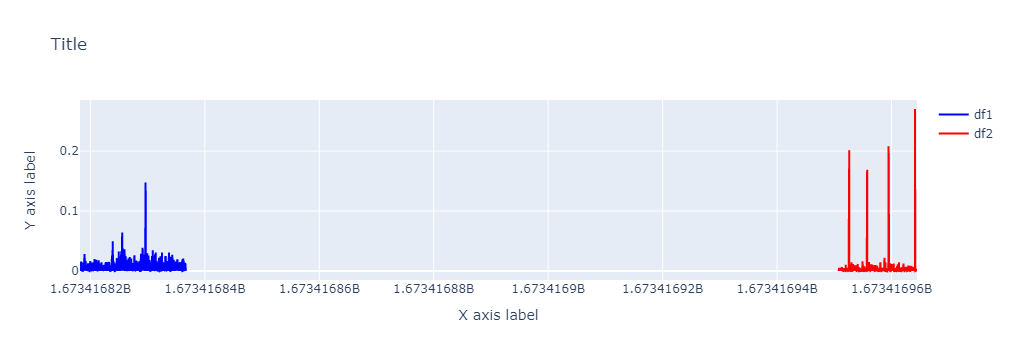

In [28]:
import plotly.graph_objs as go

# Create traces
trace1 = go.Scatter(
    x = df1["timestamp"],
    y = df1["jitter"],
    name = 'df1',
    line = dict(color = 'rgb(0, 0, 255)')
)
trace2 = go.Scatter(
    x = df2["timestamp"],
    y = df2["jitter"],
    name = 'df2',
    line = dict(color = 'rgb(255, 0, 0)')
)

# Create data and layout for plot
data = [trace1, trace2]
layout = go.Layout(title = 'Title',
                   xaxis = dict(title = 'X axis label'),
                   yaxis = dict(title = 'Y axis label'))

# Create figure and plot
fig = go.Figure(data=data, layout=layout)
fig.show()
fig.write_image("your_image.pdf")

<AxesSubplot:>

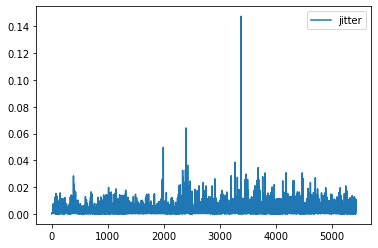

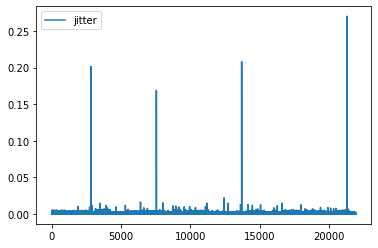

In [26]:
df1.plot()
df2.plot()

In [2]:
output_file1 = "1_wireshark.pcap"
output_file2 = "2_wireshark.pcap"

In [59]:
# df1 = tcpdump(node1,node2,h2_addr,"ens7",True)
# df2 = tcpdump(node11,node22,h22_addr,"ens7")

output_file1 = "1_1_wireshark.pcap"
output_file2 = "2_1_wireshark.pcap"
    
config_threads = {}
    
iperfSend800 = iperfSend(h2_addr,"800") 
node1.execute_thread(iperfSend800)
    
config_threads["ff1"] = node1.execute_thread(f"ffmpeg -i input.mp4 -f mpegts rtp://{h2_addr}:4444")
config_threads["tc1"] =  node2.execute_thread(f"sudo timeout 100 tcpdump -vvv -s 0 -i ens7 port 4444 -w {output_file1}") 
 
config_threads["ff2"] = node11.execute_thread(f"ffmpeg -i input.mp4 -f mpegts rtp://{h22_addr}:4444")
config_threads["tc2"] =  node22.execute_thread(f"sudo timeout 100 tcpdump -vvv -s 0 -i ens7 port 4444 -w {output_file2}") 
    
for node, thread in config_threads.items():
    stdout, stderr = thread.result()
    print(f"Config thread {node} complete")
            
        # print(stdout)



Config thread ff1 complete
Config thread tc1 complete
Config thread ff2 complete
Config thread tc2 complete


In [60]:
node2.download_file(output_file1,output_file1)
node2.execute("rm *.pcap")

node22.download_file(output_file2,output_file2)
node22.execute("rm *.pcap")



('', '')

In [5]:
df1 = pcap_to_df(output_file1)
df2 = pcap_to_df(output_file2)

In [61]:
df1['timestamp'] = df1['timestamp'].subtract(df1['timestamp'].min())
df2['timestamp'] = df2['timestamp'].subtract(df2['timestamp'].min())
df2= df2[df2['jitter'] <0.1]

df3 = df1[df1['timestamp']<df2['timestamp'].max()]
df3

timestamp    jitter      state
0      0.000000  0.000000  Congested
1      0.000895  0.000292  Congested
2      0.001209  0.000142  Congested
3      0.037267  0.035620  Congested
4      0.037281  0.000376  Congested
...         ...       ...        ...
1967  13.979454  0.000226  Congested
1968  13.979543  0.000261  Congested
1969  13.982367  0.002505  Congested
1970  13.982458  0.000269  Congested
1971  13.990121  0.006978  Congested

[1972 rows x 3 columns]

In [62]:
comparison_dict = {"Congested": df1.describe(), "Uncongested": df2.describe()}
# Use the pd.concat function to merge the describe output into a single DataFrame
comparison_table = pd.concat(comparison_dict, axis=1)

# Print the comparison table
print(comparison_table)

         Congested   Uncongested
            jitter        jitter
count  4364.000000  21971.000000
mean      0.005875      0.000703
std       0.008225      0.001211
min       0.000000      0.000000
25%       0.000344      0.000221
50%       0.003464      0.000307
75%       0.008148      0.000456
max       0.103360      0.026272


In [64]:

# # Create a figure and axis
# fig, ax = plt.subplots()

# # Plot the first dataframe
# df3.plot(kind='line', x="timestamp", y="jitter", ax=ax)

# # Plot the second dataframe on the same axis
# df2.plot(kind='line', x='timestamp', y="jitter", ax=ax)

# # Add a legend
# plt.legend(['df1', 'df2'])

# # Show the plot
# plt.show()


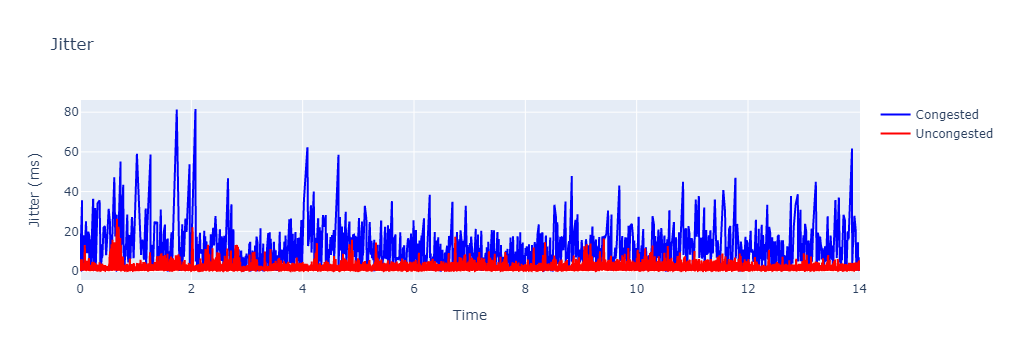

In [65]:
import plotly.graph_objs as go

# Create traces
trace1 = go.Scatter(
    x = df3["timestamp"],
    y = df3["jitter"]*1000,
    name = 'Congested',
    line = dict(color = 'rgb(0, 0, 255)')
)
trace2 = go.Scatter(
    x = df2["timestamp"],
    y = df2["jitter"]*1000,
    name = 'Uncongested',
    line = dict(color = 'rgb(255, 0, 0)')
)

# Create data and layout for plot
data = [trace1, trace2]
layout = go.Layout(title = 'Jitter',
                   xaxis = dict(title = 'Time'),
                   yaxis = dict(title = 'Jitter (ms)'))

# Create figure and plot
fig = go.Figure(data=data, layout=layout)
fig.show()
fig.write_image("jitter_graph.pdf")

In [66]:
comparison_dict = {"Congested": df3.describe(), "Uncongested": df2.describe()}
# Use the pd.concat function to merge the describe output into a single DataFrame
comparison_table = pd.concat(comparison_dict, axis=1)

# Print the comparison table
print(comparison_table)


         Congested   Uncongested
            jitter        jitter
count  1972.000000  21971.000000
mean      0.006921      0.000703
std       0.008834      0.001211
min       0.000000      0.000000
25%       0.000363      0.000221
50%       0.004724      0.000307
75%       0.009526      0.000456
max       0.081603      0.026272


In [67]:
df1a = df1
df1a["state"] = "Congested"
df1a

df2a = df2
df2a["state"] = "Uncongested"
df2a

timestamp    jitter        state
0       0.000000  0.000000  Uncongested
1       0.006403  0.005771  Uncongested
2       0.006520  0.000313  Uncongested
3       0.006626  0.000363  Uncongested
4       0.009676  0.002523  Uncongested
...          ...       ...          ...
21970  14.011075  0.000307  Uncongested
21971  14.011225  0.000248  Uncongested
21972  14.011384  0.000189  Uncongested
21973  14.011548  0.000131  Uncongested
21974  14.011720  0.000188  Uncongested

[21971 rows x 3 columns]

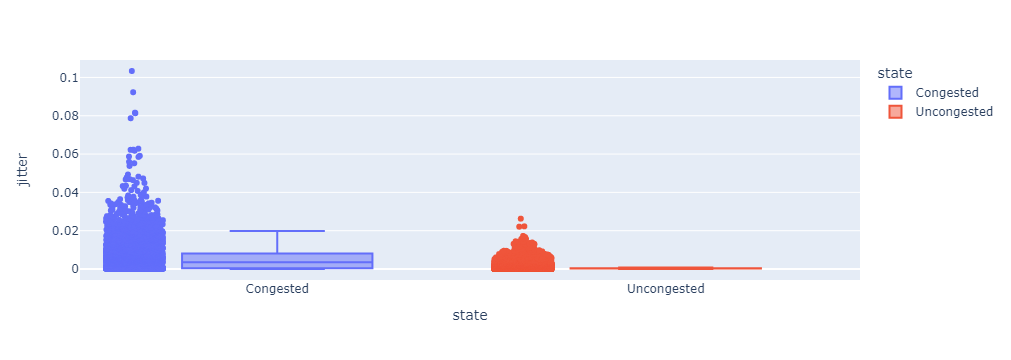

In [68]:
import plotly.express as px

fig = px.box(pd.concat([df1a, df2a]), x="state", y="jitter", color="state" , points="all")
fig.show()
fig.write_image("jitter_boxplot.pdf")

In [69]:
from scapy.utils import rdpcap

# Load the pcap file
packets = rdpcap("1_1_wireshark.pcap")

# Filter RTP packets
rtp_packets = [pkt for pkt in packets if pkt.haslayer("UDP") and pkt.haslayer("RTP")]
print(rtp_packets)
# Initialize variables to store the data
total_packets = len(rtp_packets)
lost_packets = 0
previous_seq = rtp_packets[0]['RTP'].seq

# Iterate over the RTP packets and count the lost packets
for packet in rtp_packets:
    seq = packet['RTP'].seq
    if (seq - previous_seq) > 1:
        lost_packets += (seq - previous_seq) - 1
    previous_seq = seq

# Calculate the packet loss rate
packet_loss = lost_packets / total_packets
print("Packet loss rate:", packet_loss)
rtp_packets

[]


IndexError: list index out of range

In [37]:
# node22.upload_file("requirements.txt","requirements.txt")
# node22.upload_file("input2.mp4","input2.mp4")
# node22.upload_file("object_detection.py","object_detection.py")

<SFTPAttributes: [ size=3846 uid=1000 gid=1000 mode=0o100664 atime=1673486162 mtime=1673487215 ]>

In [29]:
# node22.execute("sudo apt install -y python3-pip")
# node22.execute("pip3 install -r requirements.txt")


In [38]:
# node22.execute("pip3 install seaborn")

In [39]:
node22.execute("python3 object_detection.py")

{'person': 37}
{'person': 38, 'handbag': 1}
{'person': 39}
{'person': 39, 'handbag': 1, 'backpack': 1}
{'person': 38, 'backpack': 1, 'handbag': 1}
{'person': 38, 'handbag': 1}
{'person': 39}
{'person': 39}
{'person': 38}
{'person': 38}
{'person': 38}
{'person': 38}
{'person': 38}
{'person': 37}
{'person': 37}
{'person': 36}
{'person': 36}
{'person': 38, 'skateboard': 1}
{'person': 39}
{'person': 39}
{'person': 39}
{'person': 38}
{'person': 37}
{'person': 36}
{'person': 35}
{'person': 35}
{'person': 36}
{'person': 37}
{'person': 36}
{'person': 36, 'handbag': 1}
{'person': 37, 'handbag': 1}
{'person': 36, 'handbag': 1}
{'person': 36, 'handbag': 1, 'backpack': 1}
{'person': 34, 'handbag': 1}
{'person': 35, 'handbag': 1}
{'person': 35, 'handbag': 1}
{'person': 35, 'handbag': 1, 'backpack': 1}
{'person': 34}
{'person': 37, 'backpack': 1}
{'person': 34, 'backpack': 1, 'handbag': 1}
{'person': 36}
{'person': 35, 'backpack': 1}
{'person': 35, 'backpack': 1}
{'person': 36, 'backpack': 1, 'skis'

KeyboardInterrupt: 

In [43]:
node22.execute("ls -lh")

total 69M
drwxrwxr-x 7 ubuntu ubuntu 4.0K Jan 11 04:27 P4-VCC
-rw-rw-r-- 1 ubuntu ubuntu 2.7M Jan 11 05:24 h11_ffprobe.txt
-rw-rw-r-- 1 ubuntu ubuntu 7.3M Jan 12 03:02 input2.mp4
drwxrwxr-x 4 ubuntu ubuntu 4.0K Jan 11 04:22 jupyter-examples
-rw-rw-r-- 1 ubuntu ubuntu 4.0K Jan 12 04:31 object_detection.py
-rw-rw-r-- 1 ubuntu ubuntu  44M Jan 12 04:47 output.webm
-rw-rw-r-- 1 ubuntu ubuntu  144 Jan 12 01:18 requirements.txt
-rw------- 1 ubuntu ubuntu  15M Jan 12 01:21 yolov5s.pt


('total 69M\ndrwxrwxr-x 7 ubuntu ubuntu 4.0K Jan 11 04:27 P4-VCC\n-rw-rw-r-- 1 ubuntu ubuntu 2.7M Jan 11 05:24 h11_ffprobe.txt\n-rw-rw-r-- 1 ubuntu ubuntu 7.3M Jan 12 03:02 input2.mp4\ndrwxrwxr-x 4 ubuntu ubuntu 4.0K Jan 11 04:22 jupyter-examples\n-rw-rw-r-- 1 ubuntu ubuntu 4.0K Jan 12 04:31 object_detection.py\n-rw-rw-r-- 1 ubuntu ubuntu  44M Jan 12 04:47 output.webm\n-rw-rw-r-- 1 ubuntu ubuntu  144 Jan 12 01:18 requirements.txt\n-rw------- 1 ubuntu ubuntu  15M Jan 12 01:21 yolov5s.pt\n',
 '')